# 7章 ロジスティクスネットワークの最適設計を行う10本ノック

ここでは、最適化計算を行ういくつかのライブラリを用いて、最適化計算を実際に行っていきます。  
そして、前章で用いたネットワーク可視化などの技術を駆使し、計算結果の妥当性を確認する方法についても学んでいきます。


参照 : 
+ [ortoolpyによる最適化問題のとってもシンプルな例 - Qiita](https://qiita.com/miler0528/items/7ce838cbe9901d9fd629)
+ [Python-MIPによるモデル作成方法 — Pythonオンライン学習サービス PyQ（パイキュー）ドキュメント](https://docs.pyq.jp/python/math_opt/python_mip.html#id7)
+ [最適化におけるPython - Qiita](https://qiita.com/SaitoTsutomu/items/070ca9cb37c6b2b492f0)




In [5]:
!ls

'7章 ロジスティクスネットワークの最適設計を行う10本ノック_answer.ipynb'
'7章 ロジスティクスネットワークの最適設計を行う10本ノック.ipynb'
 demand.csv
 product_plan.csv
 product_plan_material.csv
 product_plan_profit.csv
 product_plan_stock.csv
 supply.csv
 trans_cost.csv
 trans_route_pos.csv


### ノック６１：輸送最適化問題を解いてみよう

In [1]:
# cell の大きさを100％にする
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


In [158]:
from itertools import product
import numpy as np
import pandas as pd

from pulp import LpVariable, lpSum, value, LpProblem, lpDot
from ortoolpy import model_min, addvars, addvals, addvar



In [118]:
df_trans_cost = pd.read_csv("trans_cost.csv", index_col="工場")
df_demand = pd.read_csv("demand.csv")
df_supply = pd.read_csv("supply.csv")

In [119]:
df_trans_cost

,F1,F2,F3,F4
工場,,,,
W1,10,10,11,27
W2,18,21,12,14
W3,15,12,14,12


In [134]:
df_demand


,F1,F2,F3,F4
0,28,29,31,25


In [143]:
df_supply

,W1,W2,W3
0,35,41,42


In [164]:
pr = product(df_supply.columns, df_demand.columns)
df_v = pd.DataFrame([(i, j) for i, j in pr], columns = ["Warehouse", "Factory"])
df_v["Cost"] = df_trans_cost.values.flatten()
df_v.head()


,Warehouse,Factory,Cost
0,W1,F1,10
1,W1,F2,10
2,W1,F3,11
3,W1,F4,27
4,W2,F1,18


In [165]:
m1 = model_min()

In [166]:
# 目的変数
df_v["Var"] = [LpVariable(f"v{i}", lowBound=0) for i in df_v.index]
df_v.head()

,Warehouse,Factory,Cost,Var
0,W1,F1,10,v0
1,W1,F2,10,v1
2,W1,F3,11,v2
3,W1,F4,27,v3
4,W2,F1,18,v4


In [167]:
# 目的関数
m1 += lpDot(df_v["Cost"], df_v["Var"])


In [168]:
# 制約条件
for i, df in df_v.groupby("Warehouse"):
    m1 += lpSum(df["Var"]) <= df_supply[i]

for i, df in df_v.groupby("Factory"):
    m1 += lpSum(df["Var"]) >= df_demand[i]


In [169]:
m1.solve()

1

In [170]:
df_v["num of ship"] = df_v["Var"].apply(value)
df_v

,Warehouse,Factory,Cost,Var,num of ship
0,W1,F1,10,v0,28.0
1,W1,F2,10,v1,7.0
2,W1,F3,11,v2,0.0
3,W1,F4,27,v3,0.0
4,W2,F1,18,v4,0.0
5,W2,F2,21,v5,0.0
6,W2,F3,12,v6,31.0
7,W2,F4,14,v7,5.0
8,W3,F1,15,v8,0.0
9,W3,F2,12,v9,22.0


In [172]:
(df_v["Cost"] * df_v["num of ship"]).sum()

1296.0

### ノック６２：最適輸送ルートをネットワークで確認しよう

In [191]:

import matplotlib.pyplot as plt
import networkx as nx

df_trans_cost = pd.read_csv('trans_cost.csv', index_col="工場")
df_trans_route_pos = pd.read_csv('trans_route_pos.csv')
df_trans_route_pos

print(df_trans_cost)
print(df_trans_route_pos)

    F1  F2  F3  F4
工場                
W1  10  10  11  27
W2  18  21  12  14
W3  15  12  14  12
   W1  W2  W3   F1   F2   F3   F4
0   0   0   0  4.0  4.0  4.0  4.0
1   1   2   3  0.5  1.5  2.5  3.5


In [199]:
size = 0.1
df_v["num of ship weightd"] = df_v["num of ship"] * size
df_v


,Warehouse,Factory,Cost,Var,num of ship,num of ship weightd
0,W1,F1,10,v0,28.0,2.8
1,W1,F2,10,v1,7.0,0.7
2,W1,F3,11,v2,0.0,0.0
3,W1,F4,27,v3,0.0,0.0
4,W2,F1,18,v4,0.0,0.0
5,W2,F2,21,v5,0.0,0.0
6,W2,F3,12,v6,31.0,3.1
7,W2,F4,14,v7,5.0,0.5
8,W3,F1,15,v8,0.0,0.0
9,W3,F2,12,v9,22.0,2.2


In [187]:
G = nx.Graph()


In [188]:
# 頂点を追加
for c in df_pos.columns:
    G.add_node(c)


In [227]:
df_v.apply(lambda df: G.add_edge(df["Warehouse"], df["Factory"]), axis=1 )

0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
11    None
dtype: object

In [221]:
pos = {i:tuple(r.values) for i, r in df_trans_route_pos.T.iterrows()}
pos

{'W1': (0.0, 1.0),
 'W2': (0.0, 2.0),
 'W3': (0.0, 3.0),
 'F1': (4.0, 0.5),
 'F2': (4.0, 1.5),
 'F3': (4.0, 2.5),
 'F4': (4.0, 3.5)}

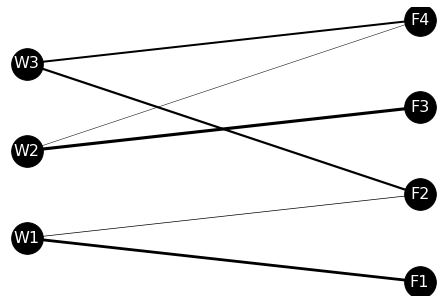

In [228]:
nx.draw(G, pos, with_labels=True,font_size=16, node_size = 1000, node_color='k', font_color='w', width=df_v["num of ship weightd"].tolist())
plt.show()

### ノック６３：最適輸送ルートが制約条件内に収まっているかどうかを確認しよう

### ノック６４：生産計画に関するデータを読み込んでみよう

### ノック６５：利益を計算する関数を作ってみよう

### ノック６６：生産最適化問題を解いてみよう

### ノック６７：最適生産計画が制約条件内に収まっているかどうかを確認しよう

### ノック６８：ロジスティクスネットワーク設計問題を解いてみよう

### ノック６９：最適ネットワークにおける輸送コストとその内訳を計算しよう

### ノック７０：最適ネットワークにおける生産コストとその内訳を計算しよう